In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
np.random.seed(2022)

In [2]:
outscale = np.loadtxt("out_scale.txt", delimiter = ", ")

In [3]:
set(outscale)

{-0.0010000000474974513,
 0.0010000000474974513,
 1004.6400146484375,
 1728000.0,
 2834700.0}

In [4]:
path = "/ocean/projects/atm200007p/jlin96/nnIngredientFactory/preprocessing/rawIngredients/"

def loadData(variation, path, normalization, split = .2, state = 2022):
    
    # specific heat of air = 1004 J/ K / kg
    # latent heat of vaporization 2.5*10^6

    heatScale = 1004
    moistScale = 2.5e6
    
    if variation == 0:
        with open(path + 'nnDataSpecific.npy', 'rb') as f:
            arr = np.load(f)
    if variation == 1:
        with open(path + 'nnDataRelative.npy', 'rb') as f:
            arr = np.load(f)
    
    X = arr[0:64,:].transpose()
    y = arr[64:,:].transpose()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, \
                                                        random_state=state)
    
    print("X_train shape: ")
    print(X_train.shape)
    print("X_test shape: ")
    print(X_test.shape)
    print("y_train shape: ")
    print(y_train.shape)
    print("y_test shape: ")
    print(y_test.shape)

    train_mu = np.mean(X_train, axis = 0)[:, np.newaxis]
    train_std = np.std(X_train, axis = 0)[:, np.newaxis]
    train_min = X_train.min(axis = 0)[:, np.newaxis]
    train_max = X_train.max(axis = 0)[:, np.newaxis]
    outscale = np.concatenate((np.repeat(heatScale, 30), np.repeat(moistScale, 30)))
    
    if normalization == "standard":
        inpsub = train_mu
        inpdiv = train_std
        
    elif normalization == "range":
        inpsub = train_min
        inpdiv = train_max - train_min
        
    norms = [inpsub, inpdiv, outscale]
    
    print("INP_SUB shape: ")
    print(inpsub.shape)
    print("INP_DIV shape: ")
    print(inpdiv.shape)
    print("outscale shape: ")
    print(outscale.shape)
    
    norm_xtrain = (X_train.transpose() - inpsub)/inpdiv
    norm_xtrain = norm_xtrain.transpose()
    norm_xtest = (X_test.transpose() - inpsub)/inpdiv
    norm_xtest = norm_xtest.transpose()
    
    norm_ytrain = np.copy(y_train)
    norm_ytrain[:, 0:30] = norm_ytrain[:, 0:30]*outscale[0:30]
    norm_ytrain[:, 30:60] = norm_ytrain[:, 30:60]*outscale[30:60]
    
    norm_ytest = np.copy(y_test)
    norm_ytest[:, 0:30] = norm_ytest[:, 0:30]*outscale[0:30]
    norm_ytest[:, 30:60] = norm_ytest[:, 30:60]*outscale[30:60]
    
    print("norm X_train shape: ")
    print(norm_xtrain.shape)
    print("norm X_test shape: ")
    print(norm_xtest.shape)
    print("norm y_train shape: ")
    print(norm_ytrain.shape)
    print("norm y_test shape: ")
    print(norm_ytest.shape)
    
    return [[X_train, X_test, y_train, y_test], [norm_xtrain, norm_xtest, norm_ytrain, norm_ytest], norms]

def plotpercs(arr, title):
    percs = np.percentile(arr, [5, 25, 50, 75, 95], axis = 0)
    for i in range(5):
        plt.plot(percs[i,:], range(arr.shape[1]))
    plt.legend(["5th", "10th", "50th", "75th", "95th"])
    plt.gca().invert_yaxis()
    plt.title("Percentiles " + title)
    plt.show()


def plotArrs(ans, partition):
    
    suffix = " (" + partition + ")"
    if partition == "train":
        xi = 0
        yi = 2
    elif partition == "test":
        xi = 1
        yi = 3
    
    #UNNORMALIZED INPUTS
    plotpercs(ans[0][xi][:, 0:30], "NNTBP Unnormalized" + suffix)
    plotpercs(ans[0][xi][:, 30:60], "Humidity Unnormalized" + suffix)
    plt.hist(ans[0][xi][:, 60], color = "grey")
    plt.title("NNPS Unnormalized")
    plt.show()
    plt.hist(ans[0][xi][:, 61], color = "yellow")
    plt.title("SOLIN Unnormalized")
    plt.show()
    plt.hist(ans[0][xi][:, 62], color = "red")
    plt.title("SHFLX Unnormalized")
    plt.show()
    plt.hist(ans[0][xi][:, 63], color = "blue")
    plt.title("LHFLX Unnormalized")
    plt.show()
    
    #UNNORMALIZED OUTPUTS
    plotpercs(ans[0][yi][:, 0:30], "TPHYSTND Unnormalized" + suffix)
    plotpercs(ans[0][yi][:, 30:60], "PHQ Unnormalized" + suffix)
    

    #NORMALIZED INPUTS
    plotpercs(ans[1][xi][:, 0:30], "NNTBP Normalized" + suffix)
    plotpercs(ans[1][xi][:, 30:60], "Humidity Normalized" + suffix)
    plt.hist(ans[1][xi][:, 60], color = "grey")
    plt.title("NNPS Normalized")
    plt.show()
    plt.hist(ans[1][xi][:, 61], color = "yellow")
    plt.title("SOLIN Normalized")
    plt.show()
    plt.hist(ans[1][xi][:, 62], color = "red")
    plt.title("SHFLX Normalized")
    plt.show()
    plt.hist(ans[1][xi][:, 63], color = "blue")
    plt.title("LHFLX Normalized")
    plt.show()
    
    #NORMALIZED OUTPUTS
    plotpercs(ans[1][yi][:, 0:30], "TPHYSTND Normalized" + suffix)
    plotpercs(ans[1][yi][:, 30:60], "PHQ Normalized" + suffix)


    #NORMALIZATION VECTORS
    plt.plot(ans[2][0][0:30], range(30))
    plt.title("INP_SUB_0-30")
    plt.gca().invert_yaxis()
    plt.show()
    
    plt.plot(ans[2][0][30:60], range(30))
    plt.title("INP_SUB_30-60")
    plt.gca().invert_yaxis()
    plt.show()
    
    print("INP_SUB_60-64: ")
    print(ans[2][0][60:64])
    print("\n")
    
    plt.plot(ans[2][1][30:60], range(30))
    plt.title("INP_DIV_0-30")
    plt.gca().invert_yaxis()
    plt.show()
    
    plt.plot(ans[2][1][30:60], range(30))
    plt.title("INP_DIV_30-60")
    plt.gca().invert_yaxis()
    plt.show()
    
    print("INP_DIV_60-64: ")
    print(ans[2][1][60:64])
    print("\n")
    
    plt.plot(ans[2][2][0:30], range(30))
    plt.title("OUTSCALE_0-30")
    plt.gca().invert_yaxis()
    plt.show()
    
    plt.plot(ans[2][2][30:60], range(30))
    plt.title("OUTSCALE_30-60")
    plt.gca().invert_yaxis()
    plt.show()

# Specific

In [5]:
filesSpecific = loadData(0, path, normalization = "standard")

X_train shape: 
(32879308, 64)
X_test shape: 
(8219828, 64)
y_train shape: 
(32879308, 60)
y_test shape: 
(8219828, 60)
INP_SUB shape: 
(64, 1)
INP_DIV shape: 
(64, 1)
outscale shape: 
(60,)
norm X_train shape: 
(32879308, 64)
norm X_test shape: 
(8219828, 64)
norm y_train shape: 
(32879308, 60)
norm y_test shape: 
(8219828, 60)


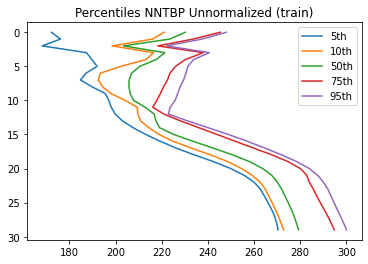

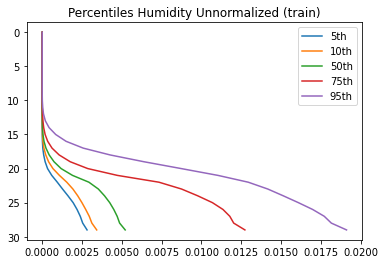

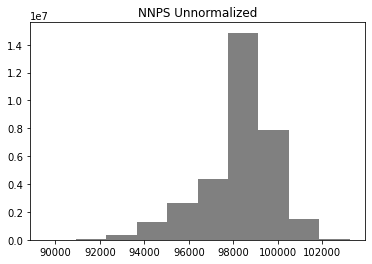

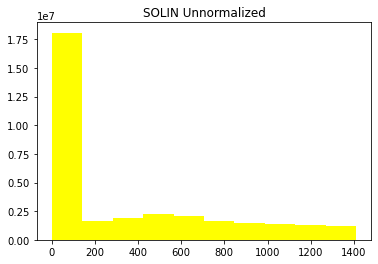

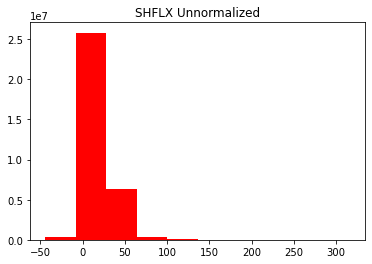

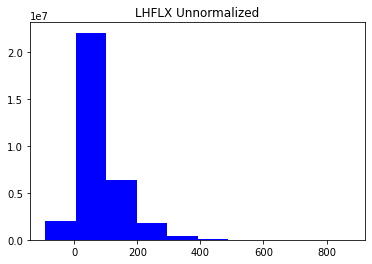

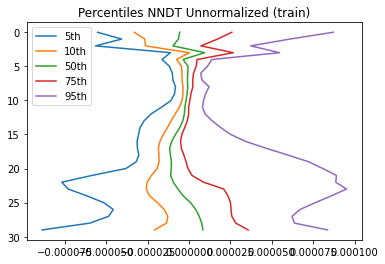

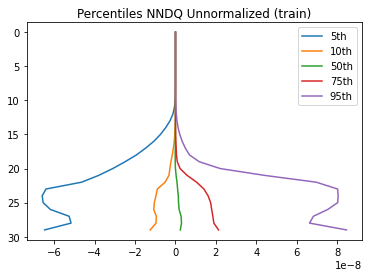

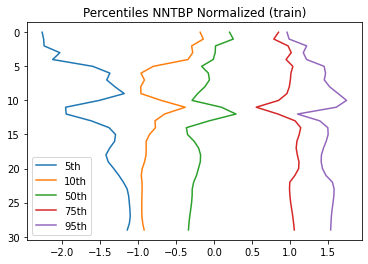

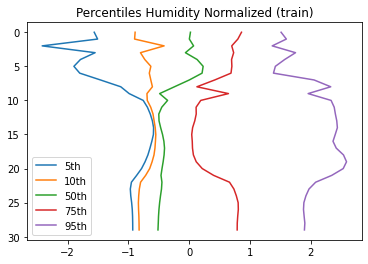

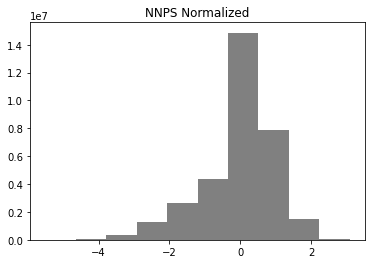

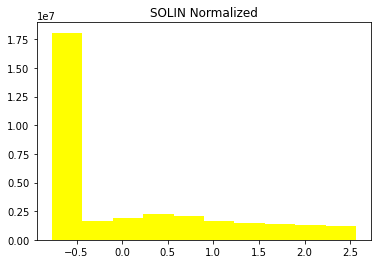

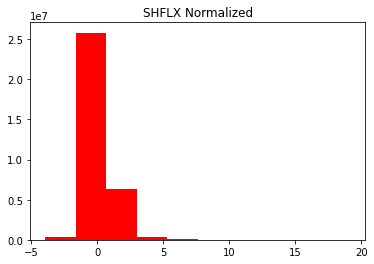

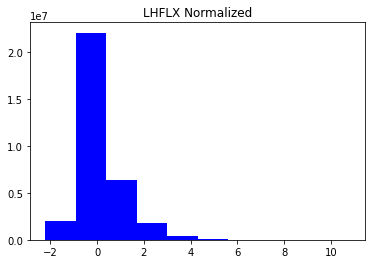

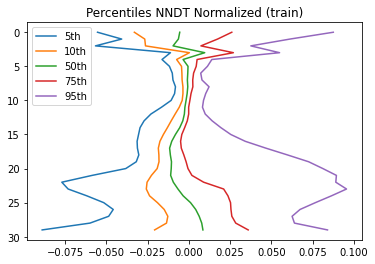

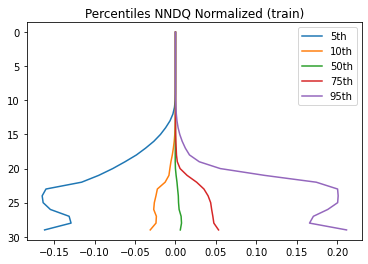

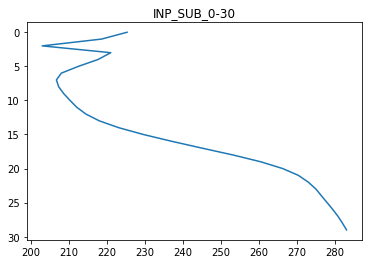

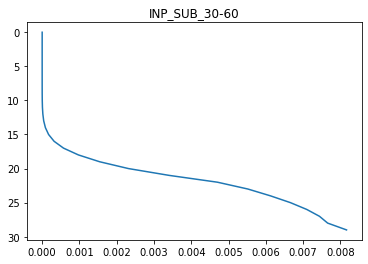

INP_SUB_60-64: 
[[9.83033714e+04]
 [3.26000573e+02]
 [1.73437784e+01]
 [7.24690554e+01]]




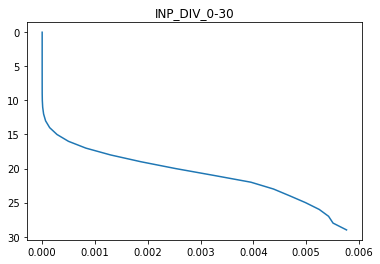

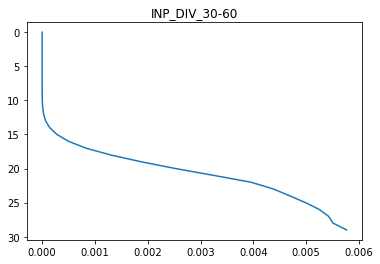

INP_DIV_60-64: 
[[1590.59530276]
 [ 422.88485912]
 [  15.60806967]
 [  74.18120515]]




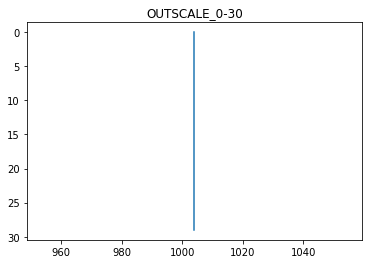

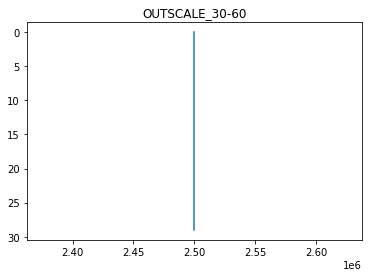

In [6]:
plotArrs(filesSpecific, "train")

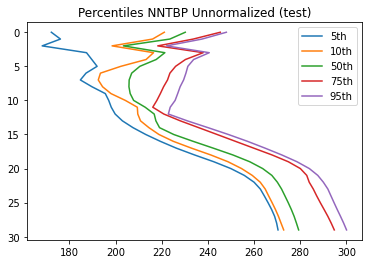

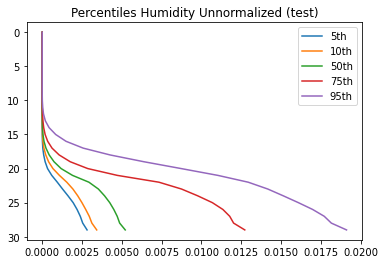

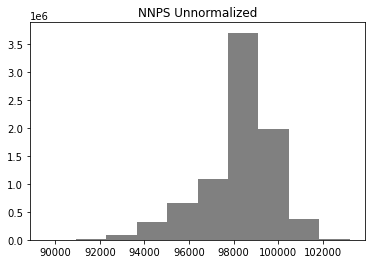

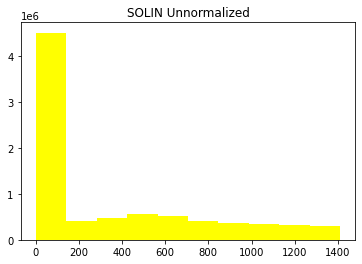

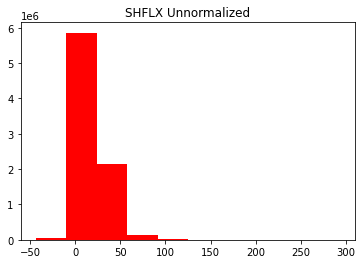

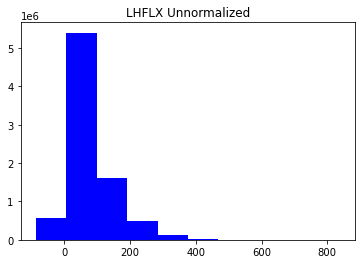

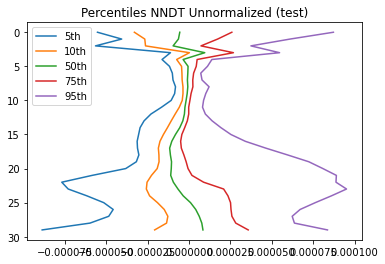

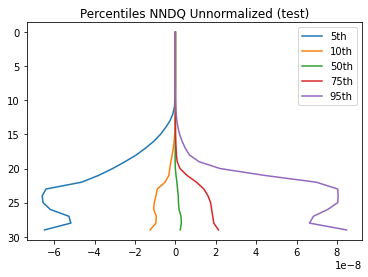

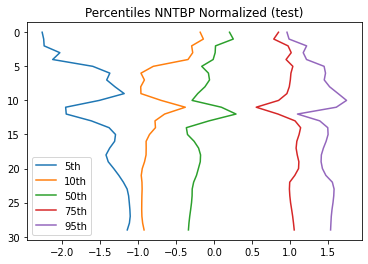

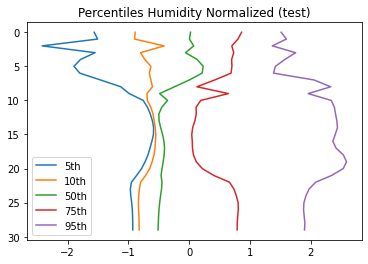

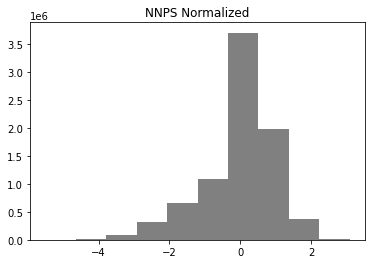

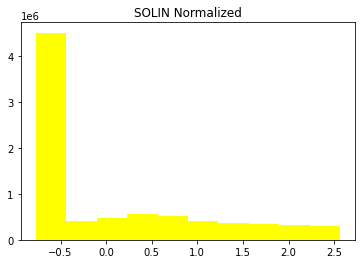

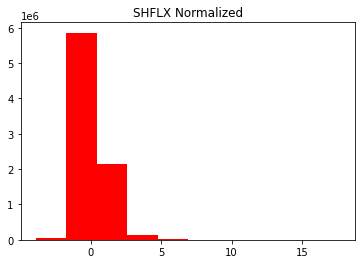

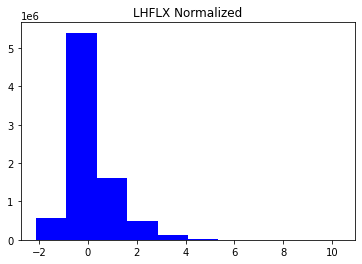

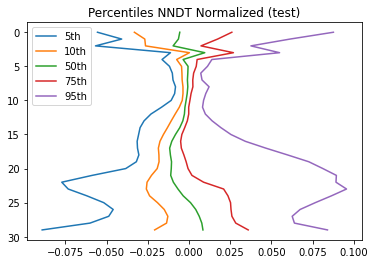

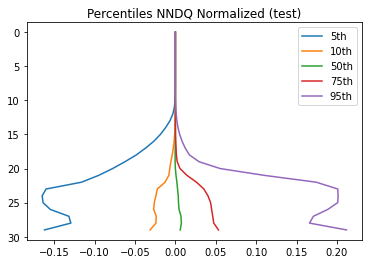

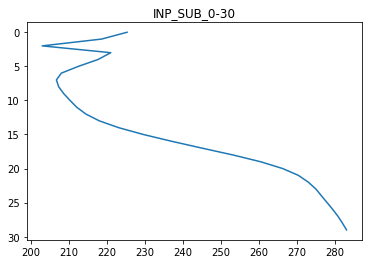

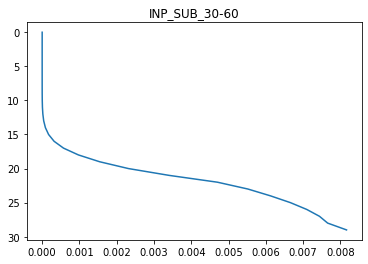

INP_SUB_60-64: 
[[9.83033714e+04]
 [3.26000573e+02]
 [1.73437784e+01]
 [7.24690554e+01]]




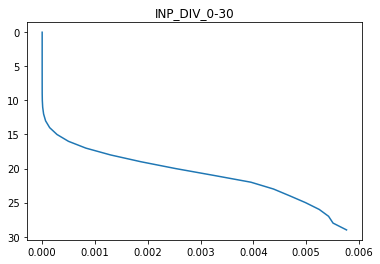

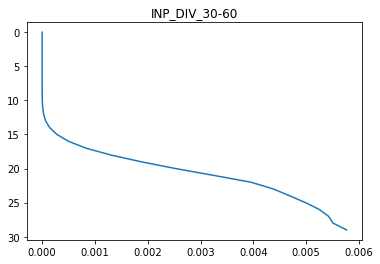

INP_DIV_60-64: 
[[1590.59530276]
 [ 422.88485912]
 [  15.60806967]
 [  74.18120515]]




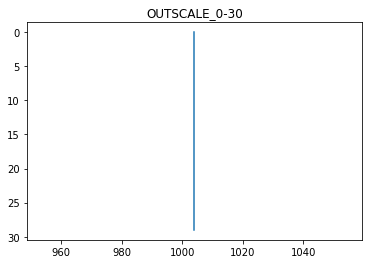

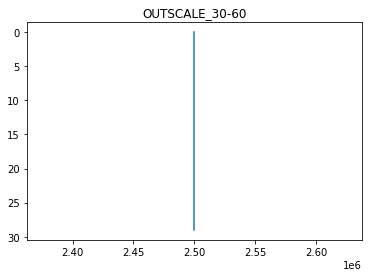

In [7]:
plotArrs(filesSpecific, "test")

# Relative

In [8]:
filesRelative = loadData(1, path, normalization = "standard")

X_train shape: 
(32879308, 64)
X_test shape: 
(8219828, 64)
y_train shape: 
(32879308, 60)
y_test shape: 
(8219828, 60)
INP_SUB shape: 
(64, 1)
INP_DIV shape: 
(64, 1)
outscale shape: 
(60,)
norm X_train shape: 
(32879308, 64)
norm X_test shape: 
(8219828, 64)
norm y_train shape: 
(32879308, 60)
norm y_test shape: 
(8219828, 60)


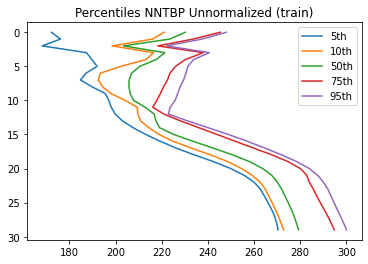

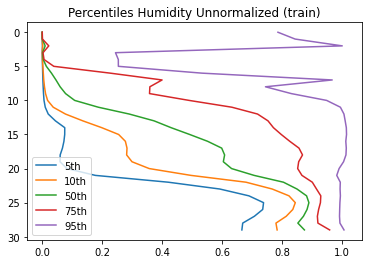

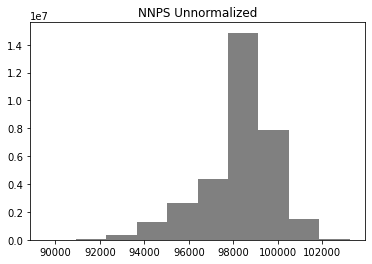

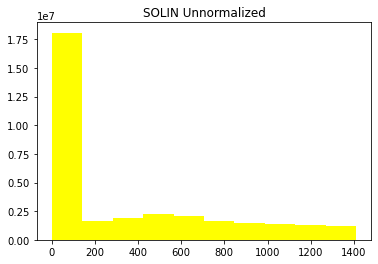

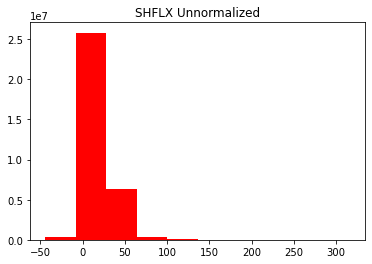

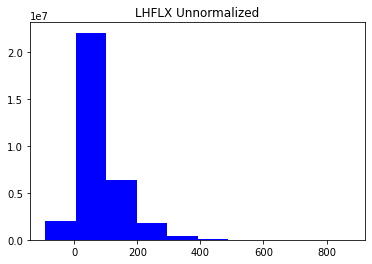

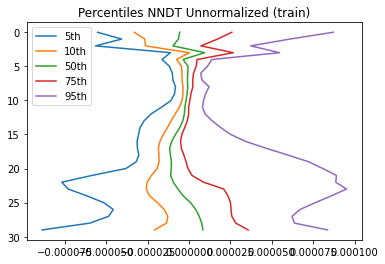

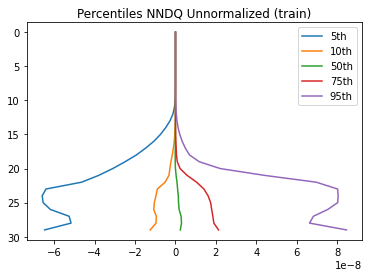

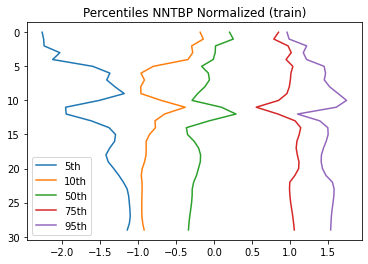

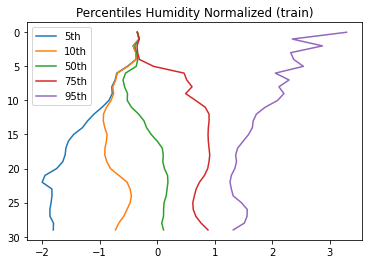

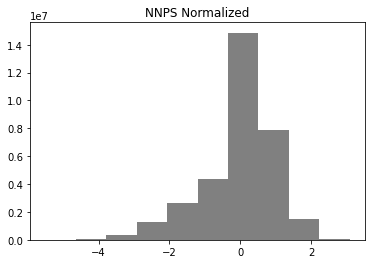

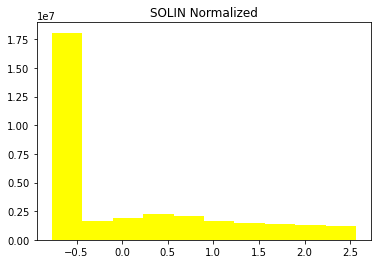

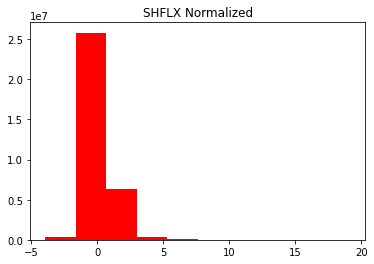

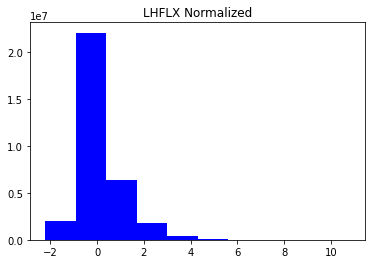

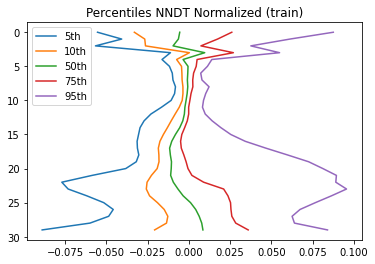

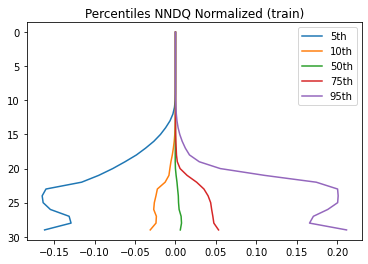

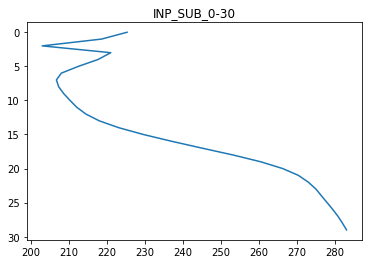

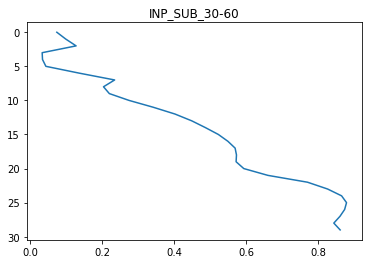

INP_SUB_60-64: 
[[9.83033714e+04]
 [3.26000573e+02]
 [1.73437784e+01]
 [7.24690554e+01]]




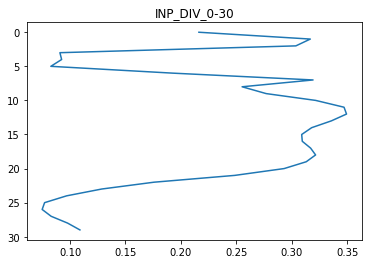

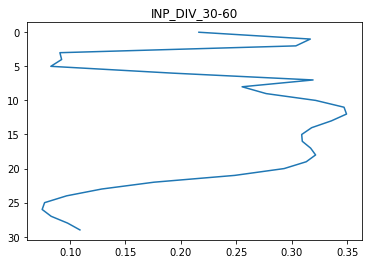

INP_DIV_60-64: 
[[1590.59530276]
 [ 422.88485912]
 [  15.60806967]
 [  74.18120515]]




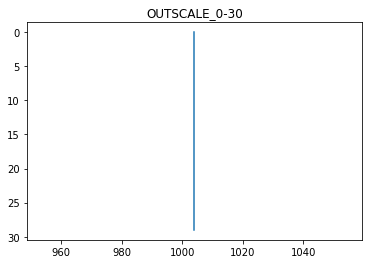

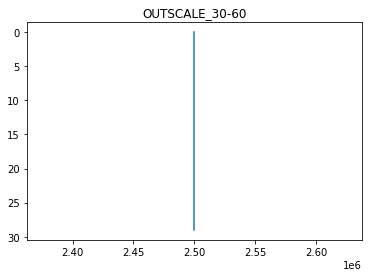

In [9]:
plotArrs(filesRelative, "train")

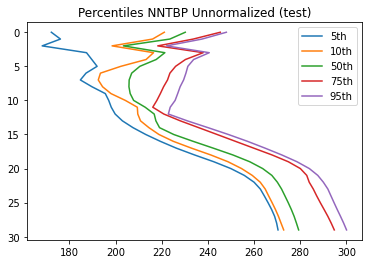

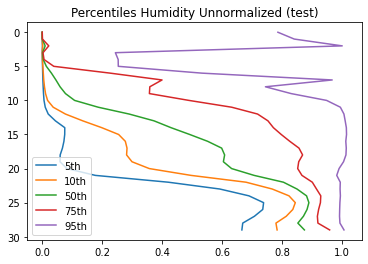

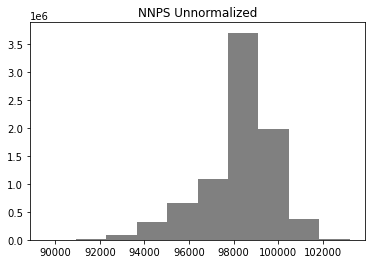

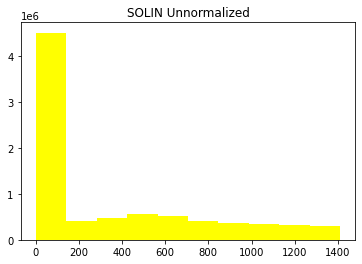

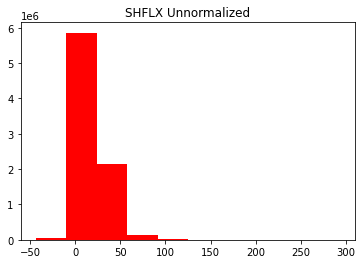

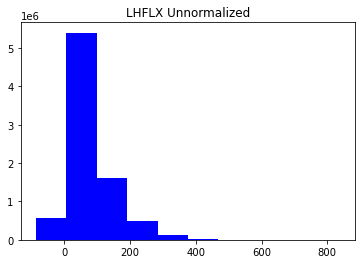

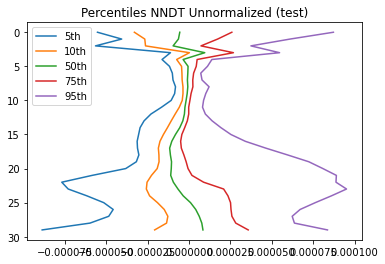

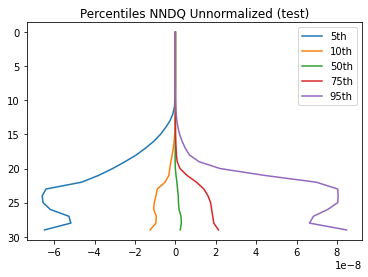

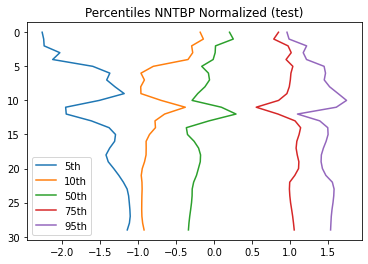

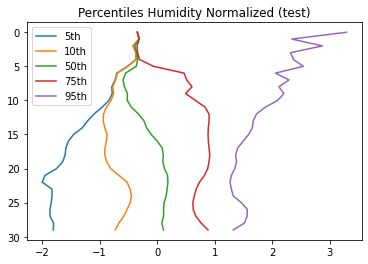

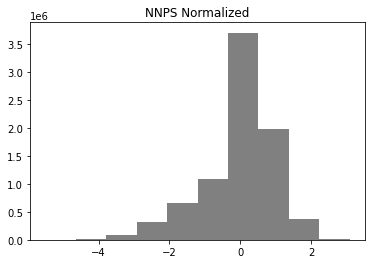

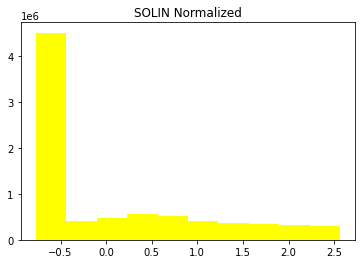

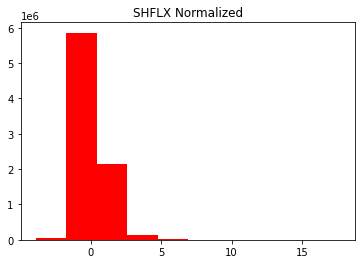

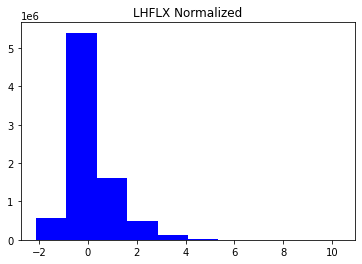

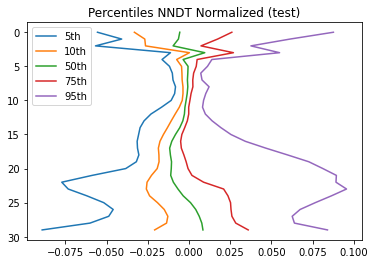

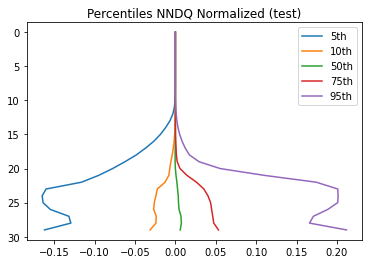

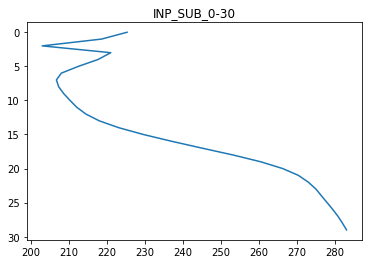

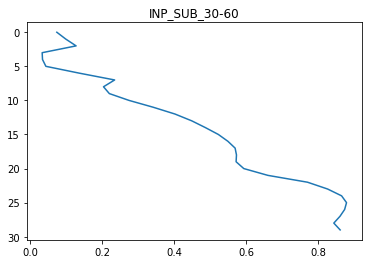

INP_SUB_60-64: 
[[9.83033714e+04]
 [3.26000573e+02]
 [1.73437784e+01]
 [7.24690554e+01]]




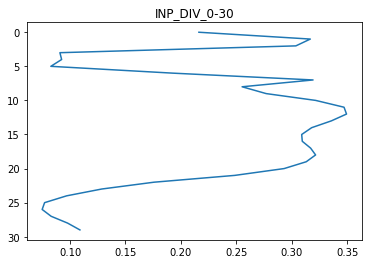

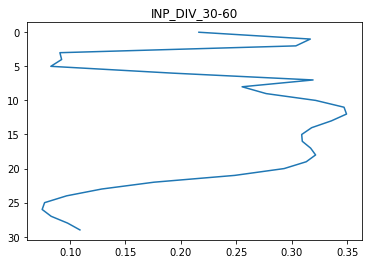

INP_DIV_60-64: 
[[1590.59530276]
 [ 422.88485912]
 [  15.60806967]
 [  74.18120515]]




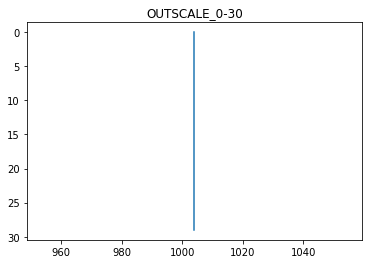

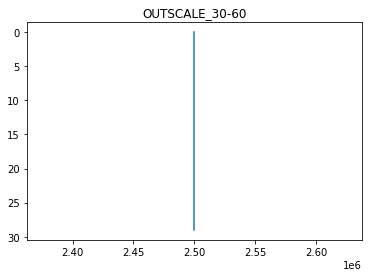

In [10]:
plotArrs(filesRelative, "test")

In [11]:
# [[X_train, X_test, y_train, y_test], [norm_xtrain, norm_xtest, norm_ytrain, norm_ytest], norms]
# sub, div, outscale

In [12]:
len(filesRelative)

3

In [13]:
len(filesSpecific)

3

In [14]:
[len(x) for x in filesRelative]

[4, 4, 3]

In [15]:
[len(x) for x in filesSpecific]

[4, 4, 3]

In [16]:
path64 = "/ocean/projects/atm200007p/jlin96/nnIngredientFactory/preprocessing/ingredients64/"
def prepareIngredients64(variation, files, path = "./"):
    if variation == 0:
        suffix = "_Specific64"
    if variation == 1:
        suffix = "_Relative64"
    with open(path + "trainInput" + suffix + ".npy", 'wb') as f:
        np.save(f, files[1][0])
    with open(path + "testInput" + suffix + ".npy", 'wb') as f:
        np.save(f, files[1][1])
    with open(path + "trainOutput" + suffix + ".npy", 'wb') as f:
        np.save(f, files[1][2])
    with open(path + "testOutput" + suffix + ".npy", 'wb') as f:
        np.save(f, files[1][3])
    np.savetxt(path64 + "inp_sub" + suffix + ".txt", files[2][0], delimiter=',')
    np.savetxt(path64 + "inp_div" + suffix + ".txt", files[2][1], delimiter=',')
    np.savetxt(path64 + "out_scale" + suffix + ".txt", files[2][2], delimiter=',')
prepareIngredients64(0, filesSpecific, path64)
prepareIngredients64(1, filesRelative, path64)

In [17]:
path32 = "/ocean/projects/atm200007p/jlin96/nnIngredientFactory/preprocessing/ingredients32/"
def prepareIngredients32(variation, files, path = "./"):
    if variation == 0:
        suffix = "_Specific32"
    if variation == 1:
        suffix = "_Relative32"
    with open(path + "trainInput" + suffix + ".npy", 'wb') as f:
        np.save(f, np.float32(files[1][0]))
    with open(path + "testInput" + suffix + ".npy", 'wb') as f:
        np.save(f, np.float32(files[1][1]))
    with open(path + "trainOutput" + suffix + ".npy", 'wb') as f:
        np.save(f, np.float32(files[1][2]))
    with open(path + "testOutput" + suffix + ".npy", 'wb') as f:
        np.save(f, np.float32(files[1][3]))
    np.savetxt(path32 + "inp_sub" + suffix + ".txt", np.float32(files[2][0]), delimiter=',')
    np.savetxt(path32 + "inp_div" + suffix + ".txt", np.float32(files[2][1]), delimiter=',')
    np.savetxt(path32 + "out_scale" + suffix + ".txt", np.float32(files[2][2]), delimiter=',')

prepareIngredients32(0, filesSpecific, path32)
prepareIngredients32(1, filesRelative, path32)

In [18]:
path16 = "/ocean/projects/atm200007p/jlin96/nnIngredientFactory/preprocessing/ingredients16/"
def prepareIngredients16(variation, files, path = "./"):
    if variation == 0:
        suffix = "_Specific16"
    if variation == 1:
        suffix = "_Relative16"
    with open(path + "trainInput" + suffix + ".npy", 'wb') as f:
        np.save(f, np.float16(files[1][0]))
    with open(path + "testInput" + suffix + ".npy", 'wb') as f:
        np.save(f, np.float16(files[1][1]))
    with open(path + "trainOutput" + suffix + ".npy", 'wb') as f:
        np.save(f, np.float16(files[1][2]))
    with open(path + "testOutput" + suffix + ".npy", 'wb') as f:
        np.save(f, np.float16(files[1][3]))
    np.savetxt(path16 + "inp_sub" + suffix + ".txt", np.float16(files[2][0]), delimiter=',')
    np.savetxt(path16 + "inp_div" + suffix + ".txt", np.float16(files[2][1]), delimiter=',')
    np.savetxt(path16 + "out_scale" + suffix + ".txt", np.float16(files[2][2]), delimiter=',')

prepareIngredients16(0, filesSpecific, path16)
prepareIngredients16(1, filesRelative, path16)

In [19]:
?np.savetxt

In [20]:
!ls

createNNingredients.ipynb		 out_scale.txt
ingredients16				 rawIngredients
ingredients32				 RelHumDataGen.ipynb
ingredients64				 SafetyChecks.ipynb
InputOutputSanityCheck.ipynb		 SubSamplingArray.ipynb
InputOutputSanityCheck_SideBySide.ipynb  Untitled.ipynb


In [21]:
np.savetxt("ingredients16/tryit.txt", np.float16([[2,4],[3,1]]), delimiter=',')